# Quantum dataset

In this notebook we will train VAIR on the quantum dataset presented in Section 3.3 of our manuscript. We will then showcase how to reproduce the different panels in Figure 4.  

## Dataset generation
We start by generating the dataset, which consists on measurements of quantum states, typical of a tomography experiment.

# Training

In [1]:
from air.datasets.quantum_exp import StateTomography, generate_quantum_dataset
import numpy as np
import torch

# We fix seeds for reproducibility
np.random.seed(11)
torch.manual_seed(11)

# We generate the dataset based on a tomography experiment with 2 qubits
dataset_size = int(6e3)
tomography = StateTomography(num_qubits=2,
                            num_measure = 75, 
                            num_random_actions= 0,
                            num_datapoints = dataset_size) 

# Dataloader parameters
batch_size = 200
beta = 1e-3
lr = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data, loader = generate_quantum_dataset(tomography, batch_size, device = device)

From here, we can see that an input observation has dimension 75, the number of measurements performed. Each action is created from a $4\times4$ complex matrix, meaning that the final action representation will have dimension $4\times4\times2 = 32$. The input to the VAIR will hence be $75+32=107$ dimensional, while the output is a single number (see manuscript for details).

In [2]:
data.dataset.tensors[0].shape, data.dataset.tensors[1].shape

(torch.Size([72000, 107]), torch.Size([72000]))

## VAIR training
We now define the VAIR architecture and train it on the previous dataset. We consider a latent space of dimension $d_z=15$ as used in the manuscript, as we expect that number of passive neurons. This is a simplification made to facilitate the visualization and understanding of VAIR properties. Similar results can be achieved with larger latent spaces. 

In [3]:
from air.models import VAIR

dim_x = tomography.num_measure # Dimension input to encoder
dim_z = 15 # Dimension latent space
dim_a = 32 # Dimension action representation
dim_y = 1 # Dimension output of decoder


vair = VAIR(dim_x = dim_x,
            dim_z = dim_z,
            dim_a = dim_a, 
            dim_y = dim_y,
           ).to(device)

We now use the fastai library to train the model. As loss, we consider the usual $\beta$-VAE loss with reconstruction objective given by the mean squared error (MSE). 

> **Important:** training this model takes around 7 minutes in a NVIDIA RTX A6000 GPU. You may need to decrease the dataset size to train in a reasonable time if you do not have access to a similar GPU. 


In [4]:
from fastai.vision.all import Learner, Adam
from air.losses_metrics import beta_mse_loss, save_separate_losses

learn = Learner(data, 
                vair,                    
                loss_func = beta_mse_loss(loss_objective = 'H',
                                          beta = beta,
                                          recon_objective='mse'), 
                opt_func= Adam
               )

    
with learn.no_logging(): learn.fit(100, lr = 1e-4)

## Analysis

Thanks to the dual encoder of VAIR, we can independently action and observation representations in the latent space.

### Action representation
We start by analyzing the output of the encoder $E_a$, so we see what are the latent neurons activated by each action in the dataset. We first obtain the projectors used for the action measurements from the tomography class and build the actions from there (this process built-in in the dataset generation function above):

In [5]:
projectors = torch.tensor(tomography.get_training_data()[-1])

action_rep = torch.cat([projectors.real.view(15, -1), 
                        projectors.imag.view(15, -1)], dim=1)

We now plot the log-variances obtained from the action encoder $E_a$ for each action in the dataset. We sort the bars such that the neuron with the lowest log-variance (i.e. the most active neuron) for each action is shown at the action index position. This facilitates visualization of which neurons are activated by each action. We also mark with a dashed line the expected position of the lowest log-variance:

''

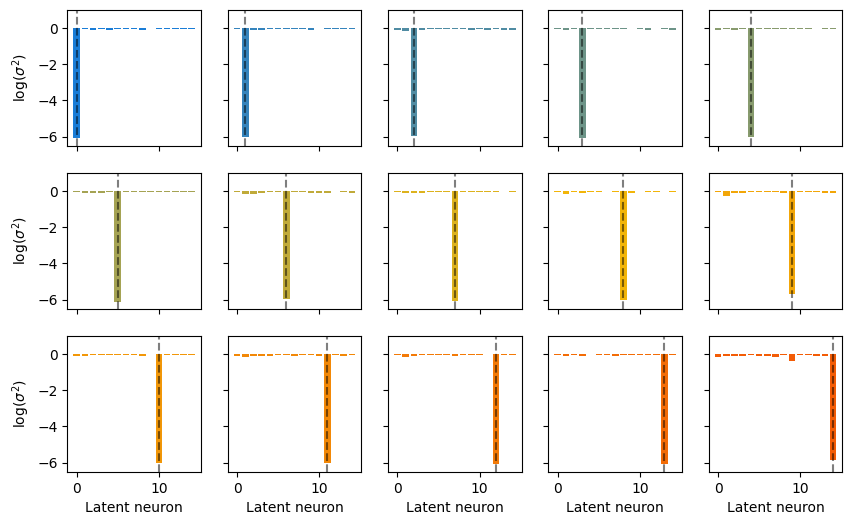

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

num_actions = 15
colors = np.array(['#1a7dd7ff', '#f2b809ff', '#f34605ff'])
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
colors_logvar = cmap(np.linspace(0., 0.9, num_actions))

fig, axs = plt.subplots(3, 5, figsize = (5*2, 3*2))

for act_idx, ax in zip(range(num_actions), axs.flatten()):

    # Passing actions to E_a encoder
    active_z = learn.E_a(action_rep[act_idx].to(torch.float).to(device)).detach().cpu()

    # Ordering bars so that the most active neuron is at the action index position
    max_index = torch.abs(active_z).argmax().item()
    indices = [i for i in range(num_actions) if i != max_index]
    indices.insert(act_idx, max_index)

    # Plot bars and dashed line at expected position
    ax.bar(np.arange(len(active_z)), [active_z[i] for i in indices], facecolor = colors_logvar[act_idx])
    ax.axvline(act_idx, ls = '--', c= 'k', alpha = 0.5)
    
plt.setp(axs, ylim = (-6.5, 1,))
plt.setp(axs[:,1:], yticklabels = [])
plt.setp(axs[:-1,:], xticklabels = [])
plt.setp(axs[:,0], ylabel = r'$\log(\sigma^2)$')
plt.setp(axs[-1,:], xlabel = 'Latent neuron')
;

### Observation representation in the latent space
We now analyze how the observations $x$ are represented in the latent space $z$. In particular, we use states of the type $\rho(r) = \frac{1}{4}\left(\mathbb{I} + r (\hat{\sigma}^{\textrm{I}}_i \otimes \hat{\sigma}^{\textrm{II}}_k)\right)$ and vary the parameter $r$. We consider different pairs of Pauli operators $(\hat{\sigma}^{\textrm{I}}_i, \hat{\sigma}^{\textrm{II}}_k)$, each of them corresponding to one action as computed above. Hence, we expect that by varying $r$, only one neuron will actually "move", while the rest will stay inactive. See all details in the manuscript.

In [8]:
# Number of r values per action. r will vary from -1 to 1
num_datapoints = 100
r_values = np.linspace(-1., 1., num_datapoints)

# We now use the built-in function to get the test data for the tomography experiment
from air.datasets.quantum_exp import get_test_data
test_data = get_test_data(tomography, num_datapoints).to(device)

/home/gorka/github/air/air/datasets/quantum_exp.py:442: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:308.)
  rho_points[idxa-1,ind] = torch.tensor(rho)


''

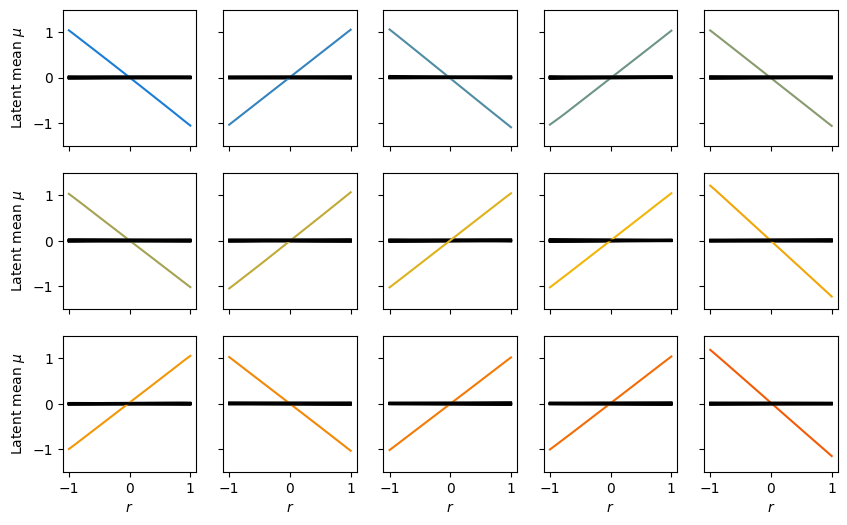

In [9]:
fig, axs = plt.subplots(3, 5, figsize = (5*2, 3*2))

colors_mu = cmap(np.linspace(0., 0.9, num_actions))

for act_idx, ax in zip(range(num_actions), axs.flatten()):

    # We first compute the logvars and use it to identify the active neuron (that with lowest logvar)
    active_z = learn.E_a(action_rep[act_idx].to(torch.float).to(device)).argmin()
    
    # We then compute the latent means for all r values and the given action
    mu_range = learn.E_x(test_data[act_idx])
    
    # Now we plot, for each latent neuron, how its mean value varies with r
    for i in range(mu_range.size(1)): 

        ax.plot(r_values, mu_range[:, i].detach().cpu(),
                # Active neuron will be colored, the rest will be black.
                # The color code follows the one used for the action representations above
                c = colors_mu[act_idx] if i == active_z else 'k')        
        
plt.setp(axs, ylim = (-1.5,1.5))
plt.setp(axs[:,1:], yticklabels = [])
plt.setp(axs[:-1,:], xticklabels = [])
plt.setp(axs[:,0], ylabel = r'Latent mean $\mu$')
plt.setp(axs[-1,:], xlabel = r'$r$')
;

As we can see, a single neuron (the active one) is proportional to the changes of $r$ when that is varying the strength of the projector encoded in each neuron. See manuscript and Figure 4b for all details.

### Action combination
We now consider the case in which the input action is the weighted combination of different actions, i.e. $A = v^{(1)}a^{(1)} + v^{(2)}a^{(2)} + v^{(3)}a^{(3)}$. We will analyze how the action encoder $E_a$ represents this mixed action in the latent space. In particular, we will see that the neurons that are active for each separate action all remain active for the mixed action, although at different strengths!

In [10]:
# We chose three actions and weights for the combination
actions_chosen = [4,1,2]
v_n = np.array([0.45,0.35,0.2])

# Now we generate the action combination. At the same time, we compute the logvar for each
# separate action, as we will need that for plotting.
mixed_action = 0
active_zs_idx, active_zs_value = [], []
for action_idx, weight in zip(actions_chosen, v_n):
    mixed_action += weight*action_rep[action_idx]

    logvars = learn.E_a(action_rep[action_idx].to(torch.float).to('cuda')).detach().cpu()
    
    active_zs_idx.append(int(logvars.argmin()))
    active_zs_value.append(int(logvars.min()))

# Finally, we compute the logvars of the mixed action
logvars_mixed = learn.E_a(mixed_action.to(torch.float).to('cuda')).detach().cpu()

Let's now plot the resulting log-variances:

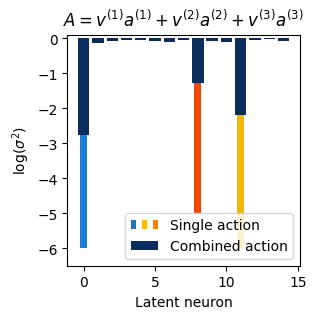

In [12]:
fig, axs = plt.subplots(1, 1, figsize = (3, 3))

# We plot the logvars of the mixed action
axs.bar(np.arange(len(logvars_mixed)), logvars_mixed, color='#0b2c5d', zorder = 10)

# In same colors, but with lower widths and transparencies, we plot the logvars of the separate actions
for idx, (val, x) in enumerate(zip(active_zs_value, active_zs_idx)):
    axs.bar(x, val, color = colors[idx], width = 0.5)

# Legend
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerTuple
single_action = tuple(Rectangle((0, 0), 1, 1, fc=c) for c in ["#1f77b4", "#ffbf00","#ff7f0e"])
combined_action = Rectangle((0, 0), 1, 1, fc="#0b2c5d")
axs.legend([single_action, combined_action],
          ["Single action", "Combined action"],
          handler_map={tuple: HandlerTuple(ndivide=None)}
         )
# Plot labels
plt.setp(axs, ylim = (-6.5, 0.1), 
         ylabel = r'$\log(\sigma^2)$', xlabel = 'Latent neuron',
         title = r'$A = v^{(1)}a^{(1)} + v^{(2)}a^{(2)} + v^{(3)}a^{(3)}$');

As we can see, the logvars for a mixed action correspond to those that would be active for each separate action. Moreover, the value of the logvar directly depends on the $w_i$ for each of the actions, as we can see in the following plot:

Text(0, 0.5, 'Log-variance of active neuron')

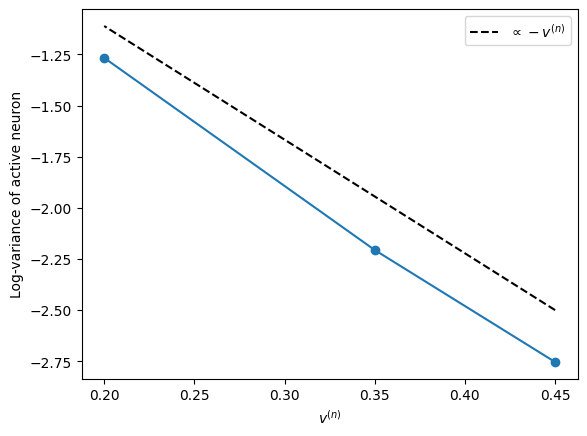

In [13]:
plt.plot(v_n, logvars_mixed[active_zs_idx], '-o')
plt.plot(v_n, -2.5*v_n/v_n[0], c = 'k', ls = '--', label = r'$\propto -v^{(n)}$')
plt.legend()
plt.xlabel(r'$v^{(n)}$')
plt.ylabel('Log-variance of active neuron')

This (short) analysis matches the results shown Fig. 4d, were we run the same study but for a large number of random weights and actions combinations.